# 0. Drahtlose Kommunikation

## 0.1 Bildquellen und Vorlesungsinhalte
Die in diesem Dokument verwendeten Bilder, sofern sich nicht mit dem hier aufgeführten Code generiert wurden, stammen aus dem PC-Übungsskript "Drahtlose Kommunikation - MATLAB Rechenübung" von Dipl. -ing Lutz Molle und Prof. Dr. -ing. Markus Nölle an der HTW Berlin. Sie wurden teilsweise zur besseren Darstellung von mir verändert.


# 1. Simulation des Übertragungssystems

Die Funktionen werden immer paarweise implementiert, da sie ähnlich wie beim OSI Modell komplementäre Funktionen ausüben.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
from typing import List, Set, Dict, Tuple, Any, Callable

In [2]:
%load_ext lab_black
IPython.display.set_matplotlib_formats("pdf", "svg")

## 1.1 Quelle und Senke
![Quelle und Senke](Images/01_Quell_Senke.png)

In [3]:
def generate_bits(n_bits: int) -> List[np.ndarray]:
    """
    Generate numpy array with n_bits values.

    n_bits: Number of bits to generate
    :return: Randomly generated bits.
    """

    if not isinstance(n_bits, int):
        raise TypeError("Expected n_bits to be of type int.")

    bit_vector: np.ndarray = np.random.randint(0, 2, size=n_bits)
    return bit_vector

In [4]:
def count_errors(
    true_values: np.ndarray, tested_values: np.ndarray
) -> Tuple[int, float]:
    """
    Get two bit vectors an compere them.
    Returns count of different bits an bit-error-racio.
    The lenth of both vectors should be equal.
    Both input vectors must be of type bool.

    true_values: Original values.
    tested_values: Values to compare to original values.
    """

    if len(true_values) != len(tested_values):
        raise ValueError("Lengths of bit vectores are different.")
    for item in true_values:
        if item != 0 and item != 1:
            raise TypeError(f"Expected true_values to be ether 0 or 1. Got: {item}")
    for item in tested_values:
        if item != 0 and item != 1:
            raise TypeError(f"Expected tested_values to be ether 0 or 1. Got: {item}")

    equal_bits: np.ndarray = true_values == tested_values
    n_error: int = len(true_values) - int(np.count_nonzero(equal_bits))
    bit_error_rate: float = n_error / len(true_values)
    return (n_error, bit_error_rate)

# 1.1 Kanal codierung
![Kanal codierung](Images/02_Kanal_Codierung.png)

# 1.2 Mapper, Demapper, Entscheider
![Mapper, Demapper, Entscheider](Images/03_Mapper.png)

In [5]:
def mapper(bits: np.ndarray, constellation: Dict[Tuple, complex]) -> np.ndarray:
    """
    Get array of bits and map them to an array of symbols.
    Bit vector length and constellation vector length must agree.

    bits: Bits to map to symbols.
    constellation: Available symbols to map to.
    :return: Mapped symbols.
    """
    len_bits: int = len(bits)
    len_constellation: int = len(constellation)

    symbols: List[complex] = []
    slices: List[complex] = []
    bits_per_symbol: int = int(np.log2(len_constellation))
    bit_nr: int = 0
    for bit in bits:
        slices.append(bit)
        if len(slices) >= bits_per_symbol:
            symbols.append(constellation[tuple(slices)])
            slices = []
    if len(slices) > 0:
        raise ValueError(
            f"Bit vector has not the right length. There are {len(slices)} bit(s) to much."
        )

    return np.array(symbols)

In [31]:
def decission(symbols: np.ndarray, constellation: Dict[Tuple, complex]) -> np.ndarray:
    """
    Get array of symbols. Return array of symboles where eukledian
    distance to the origianl Symbol.

    symbols: List of noisy input symbols.
    constallation: Table of constallation symbols.
    :return: List of decided symbols.
    """

    constellation_list: List[complex] = [constellation[key] for key in constellation]
    constellation_vector: np.ndarray = np.array(constellation_list)
    decission: List[complex] = []
    for symbol in symbols:
        distance: List[complex] = []
        for const_symbol in constellation_vector:
            distance.append(np.linalg.norm(const_symbol - symbol))
        const_index = distance.index(min(distance))
        decission.append(constellation_vector[const_index])
    return np.array(decission)

In [7]:
def demapper(symbol: np.ndarray, constellation: dict[Tuple, complex]) -> np.ndarray:
    """
    Get symbol and retunrns corresponding bit sequence.

    symbol: Sybol carring bit information.
    constellation: Constellation Table to decode.
    :return: Byte information.
    """
    len_constellation: int = len(constellation)
    len_bits: numpy.ndarray = int(
        np.log(len_constellation) / np.log(2)
    )  # Bit const_len should be 2**bit_len

    bits_tupel = constellation[symbol]
    # bit vector lenth depends on constellation lenth
    # bit vector value depends on position in constellation vector
    bits_string = ("{0:0" + f"{len_bits}" + "b}").format(bits_integer)
    bits = [
        bool(int(bit)) for bit in bits_string
    ]  # int cast because "0"-String is True
    return bits

# 1.3 Kanal (Funk, Kabel, ...)
![Kanal (Funk, Kabel, ...](Images/04_Kanal.png)

In [8]:
def awgn():
    pass

In [9]:
def radio_fading_channel():
    pass

# 2. Demonstration der einzelnen Funktionen
## 2.1 Quelle und Senke
### 2.1.1 Quelle
Die Quelle generiert eine beliebige anzahl (n_bits) an [zufälligen](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.htmlhttps://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html) bits.

In [10]:
random_bits: np.ndarray = generate_bits(10)

print(f"Zufällige bits: {random_bits}")

Zufällige bits: [0 0 1 0 0 0 0 0 1 1]


### 2.1.2 Senke
In der Senke werden die eingegangen bits mit den eigentlich gesendeten Bits verglichen. Es wird die absolute Anzahl an flaschen Bits sowie die BER (Bit error rate) berechnet.  
BER = $\frac{richtig\_empfangen}{absolut\_empfangen}$

In [11]:
true_values: np.ndarray = np.array([1, 0, 1, 0])
test_values: np.ndarray = np.array([0, 0, 1, 1])
bit_errors: int
ber: float
bit_errors, ber = count_errors(true_values, test_values)

print(f"Gesendete Bits:  {true_values}")
print(f"Empfangene Bits: {test_values}")
print(f"Falsche Bits:    {bit_errors}")
print(f"BER:             {ber}")

Gesendete Bits:  [1 0 1 0]
Empfangene Bits: [0 0 1 1]
Falsche Bits:    2
BER:             0.5


## 2.2 Mapper, Demapper, Entscheider
### 2.2.1 Mapper
Der Mapper weist einer Bit-Gruppe ein Konstellationssymbol zu. Je nach Anzahl der Konstallationssymbole kann ein Symbol die Information von mehereren Bits tragen.
$symbol_{anz} \hat{=} 2^{bit_{anz}}$

In [12]:
bits: np.ndarray = np.array([1, 0])
constellation: Dict[Tuple, complex] = {
    (0, 0): -1 - 1j,
    (0, 1): -1 + 1j,
    (1, 0): +1 - 1j,
    (1, 1): +1 + 1j,
}
mapped_symbols: np.ndarray = mapper(bits, constellation)
print(f"Konstellations Tabelle:")
for key in constellation:
    print(f"{key} = {constellation[key]}")
print(f"Bits:   {bits}")
print(f"Mapped: {mapped_symbols}")

Konstellations Tabelle:
(0, 0) = (-1-1j)
(0, 1) = (-1+1j)
(1, 0) = (1-1j)
(1, 1) = (1+1j)
Bits:   [1 0]
Mapped: [1.-1.j]


In [50]:
def plot_symbols(symbols: np.ndarray) -> None:
    ORIGIN = (0, 0)

    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=[4, 4])
    fig.suptitle(f"Symbol{'e' if len(symbols) > 1 else ''} auf der Komplexen ebene.")

    ax = fig.add_subplot(axs)
    ax.grid(True)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel("Real")
    ax.set_ylabel("Imaginär")

    for symbol in symbols:
        ax.arrow(
            *ORIGIN,
            symbol.real,
            symbol.imag,
            length_includes_head=True,
            head_width=0.075,
            head_length=0.1,
            fc="black",
            ec="black",
        )
    # plt.arro1(0, 0, 1, 1, color=["r"], scale=21)
    plt.show()

Darstellung des Symbols auf der komplexen Ebene

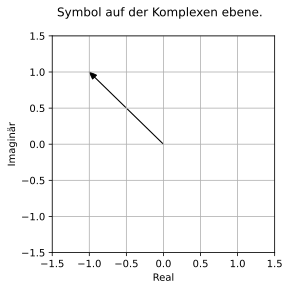

In [51]:
bits: np.ndarray = np.array([0, 1, 1, 0])
constellation: Dict[Tuple, complex] = {
    (0, 0): -1 - 1j,
    (0, 1): -1 + 1j,
    (1, 0): +1 - 1j,
    (1, 1): +1 + 1j,
}
mapped_symbols: np.ndarray = mapper(bits, constellation)
plot_symbols([mapped_symbols[0]])

### 2.2.2 Entscheider
Entscheidet sich für das Symbol, welches zu dem empfangen Symbol die geringste eukliedische Distanz hat.

Noisy symbols:   [ 1.1+0.9j -1.2-1.3j -1. +0.9j]
Decided symbols: [ 1.+1.j -1.-1.j -1.+1.j]


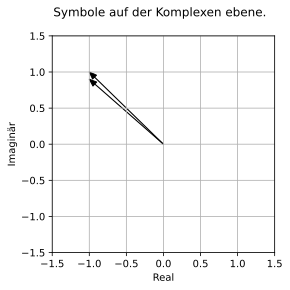

In [52]:
constellation: Dict[Tuple, complex] = {
    (0, 0): -1 - 1j,
    (0, 1): -1 + 1j,
    (1, 0): +1 - 1j,
    (1, 1): +1 + 1j,
}
noisy_symbols: np.ndarray = np.array([1.1 + 0.9j, -1.2 - 1.3j, -1 + 0.9j])
decision_symbols: np.ndarray = decission(noisy_symbols, constellation)
print(f"Noisy symbols:   {noisy_symbols}")
print(f"Decided symbols: {decision_symbols}")
plot_symbols([noisy_symbols[2], decision_symbols[2]])

### 2.2.3 Demapper

In [16]:
constellation: List[complex] = [-1 - 1j, -1 + 1j, 1 - 1j, 1 + 1j]
symbols: List[complex] = [-1 + 1j, -1 - 1j, -1 + 1j]
demapper(symbols[0], constellation)

[False, True]

# 3. Komplette Simulation